# Import all libraries

In [216]:
from Mnist_Classifier_CNN import MNIST_CNN
from Mnist_Classifier_NN import MNIST_NN

import random
from tqdm import tqdm
import torch
import torch.nn as nn
from torchsummary import summary
import torchvision
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse

### Check if GPU is available

In [217]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    !nvidia-smi
    print(torch.cuda.get_device_name(0))

else:
    print("No GPU :(")


Tue Sep  6 17:42:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   45C    P3    16W /  N/A |   1622MiB /  4096MiB |     18%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Load MNIST dataset

In [218]:
dataset = torchvision.datasets.MNIST(root = 'datasets', train = True, download = True, transform=torchvision.transforms.ToTensor())

#### Get and visualize random individual

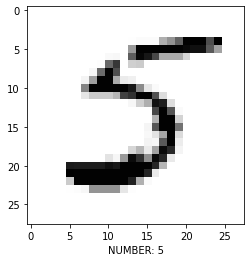

In [219]:
rand_individ = random.randint(0, 60_000)
img = dataset[rand_individ][0].view((28, 28))
ans = dataset[rand_individ][1]
plt.imshow(img, cmap='Greys')
plt.xlabel(f"NUMBER: {ans}")
pass

# Prepare and split data into train/test

In [220]:
split_ratio = 0.90
batch_size = 50
train_size = round(len(dataset) * split_ratio)
valid_size = len(dataset) - train_size

train, valid = torch.utils.data.random_split(dataset, [train_size, valid_size])

train_batch_loader = torch.utils.data.DataLoader2(train, batch_size=batch_size, collate_fn=lambda x: tuple(x_.to(device) for x_ in torch.utils.data.dataloader.default_collate(x)))
valid_batch_loader = torch.utils.data.DataLoader2(valid, batch_size=batch_size, collate_fn=lambda x: tuple(x_.to(device) for x_ in torch.utils.data.dataloader.default_collate(x)))

# Configure NN Model and hyper-parameters

In [221]:
mnist_nn = MNIST_NN(28*28, 10).to(device)

epochs = 5
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.ASGD(mnist_nn.parameters(), lr=0.8)

history = []
summary(mnist_nn, (28*28,), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [50, 512]         401,920
              ReLU-2                  [50, 512]               0
            Linear-3                  [50, 256]         131,328
              ReLU-4                  [50, 256]               0
            Linear-5                   [50, 10]           2,570
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.15
Forward/backward pass size (MB): 0.59
Params size (MB): 2.04
Estimated Total Size (MB): 2.78
----------------------------------------------------------------


# Train loop

In [222]:
for epoch in range(0, epochs):
    for i, (features, ans) in enumerate(tqdm(train_batch_loader)):
        # Forward pass
        Y_pred = mnist_nn.forward(features.view(-1, 28*28))

        loss = loss_func(Y_pred, ans)

        # Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if i % 3 == 0: history.append(loss.data)

100%|██████████| 1080/1080 [00:06<00:00, 162.45it/s]


Mean CrossEntropyLoss (last 100): 0.03481148183345795


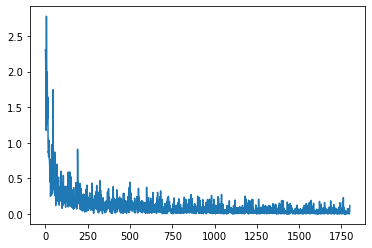

In [223]:
plt.plot(list(map(lambda x: x.cpu(), history)))
print(f"Mean CrossEntropyLoss (last 100): {sum(history[-100:]) / 100}")

# Validation

In [224]:
with torch.no_grad():
    answers = torch.zeros(10).to(device)
    predictions = torch.zeros(10).to(device)

    for i, (features, ans) in enumerate(tqdm(valid_batch_loader)):
        predictions = torch.vstack((predictions, nn.functional.normalize(mnist_nn(features.view(-1, 28*28)))))

        # Convert to one-hot encoded
        ans = nn.functional.one_hot(ans, num_classes=10)

        answers = torch.vstack((answers, ans))

    print(f"MSE: {mse(predictions.T.cpu(), answers.T.cpu())}")


100%|██████████| 120/120 [00:00<00:00, 210.13it/s]

MSE: 0.04415731504559517


# Visualisation test

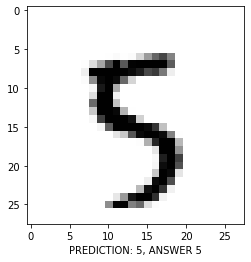

In [225]:
rand_individ = random.randint(0, 60_000)
img = dataset[rand_individ][0].view((28, 28))
ans = dataset[rand_individ][1]


with torch.no_grad():
    pred = mnist_nn(img.to(device).view(-1)).argmax()

plt.imshow(img, cmap='Greys')
plt.xlabel(f"PREDICTION: {pred}, ANSWER {ans}")
pass 

# Configure CNN Model and hyper-parameters

In [226]:
mnist_cnn = MNIST_CNN().to(device)

epochs = 2
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_cnn.parameters(), lr=0.01)

history = []
summary(mnist_cnn, (1, 28, 28), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [50, 10, 26, 26]             100
              ReLU-2           [50, 10, 26, 26]               0
            Conv2d-3           [50, 30, 24, 24]           2,730
              ReLU-4           [50, 30, 24, 24]               0
         MaxPool2d-5           [50, 30, 12, 12]               0
            Conv2d-6           [50, 50, 10, 10]          13,550
              ReLU-7           [50, 50, 10, 10]               0
         MaxPool2d-8             [50, 50, 5, 5]               0
            Linear-9                  [50, 250]         312,750
             ReLU-10                  [50, 250]               0
           Linear-11                   [50, 10]           2,510
Total params: 331,640
Trainable params: 331,640
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.15
Forward/

# Train loop

In [227]:
for epoch in range(0, epochs):
    for i, (features, ans) in enumerate(tqdm(train_batch_loader)):
        # Forward pass
        Y_pred = mnist_cnn.forward(features.view(-1, 1, 28, 28))
        # print(Y_pred.shape)

        loss = loss_func(Y_pred, ans)

        # Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if i % 3 == 0: history.append(loss.data)

100%|██████████| 1080/1080 [00:09<00:00, 112.45it/s]


Mean CrossEntropyLoss (last 100): 0.06815779209136963


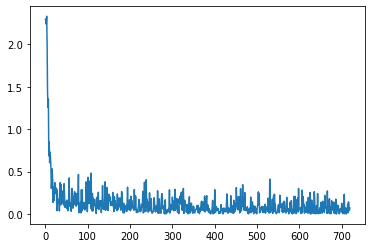

In [228]:
plt.plot(list(map(lambda x: x.cpu(), history)))
print(f"Mean CrossEntropyLoss (last 100): {sum(history[-100:]) / 100}")

# Validation

In [229]:
with torch.no_grad():
    answers = torch.zeros(10).to(device)
    predictions = torch.zeros(10).to(device)

    for i, (features, ans) in enumerate(tqdm(valid_batch_loader)):
        predictions = torch.vstack((predictions, nn.functional.normalize(mnist_cnn(features.view(-1, 1, 28, 28)))))

        # Convert to one-hot encoded
        ans = nn.functional.one_hot(ans, num_classes=10)

        answers = torch.vstack((answers, ans))

    print(f"MSE: {mse(predictions.T.cpu(), answers.T.cpu())}")

100%|██████████| 120/120 [00:00<00:00, 154.32it/s]

MSE: 0.09239758551120758
